In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [19]:
#Import data
df = pd.read_csv('merged10.csv')

#Assign variables
data = df.values[:, 4:107].astype(float) #Feature 4:107
target = df.values[:, 107:120].astype(int) #Class 107:120
d_name = np.array(df.columns[4:107])
t_name = np.array(df.columns[107:120])
target1 = target[:,11] #Change this value from 7-12 to change target set 

print(np.shape(df.values[:,:]))
print(t_name[7], t_name[9], t_name[11]) 

(2610, 120)
Rate_case_Day30 Rate_death_Day30 Rate_fatality_Day30


In [14]:
#Important feature names
Target = 0 #incidence, mortality, case fatality

if Target == 0:
    print(d_name[[1,0,100,26,15,101,99,24,29,98,6,3,27,25,102]])
elif Target == 1:    
    print(d_name[[2,1,3,0,29,26,45,95,63,19,8,74,39,49,12]])
elif Target == 2:
    print(d_name[[1,0,98,101,63,29,7,3,100,25,99,65,6,24,26]])

['Long' 'Lat' 'percent_excessive_drinking'
 'Percent.of.adults.completing.some.college.or.associate.s.degree.2014.18'
 'Income' 'percent_adults_with_obesity' 'percent_physically_inactive'
 'Percent.of.adults.with.less.than.a.high.school.diploma.2014.18'
 'MEDHHINC_2018' 'percent_smokers' 'NATURALINC2019' 'NPOPCHG_2019'
 'Percent.of.adults.with.a.bachelor.s.degree.or.higher.2014.18'
 'Percent.of.adults.with.a.high.school.diploma.only.2014.18'
 'percent_vaccinated']


In [ ]:
#View all feature names
for i in range(0, 103):
    print(i, d_name[i])

# Data Processing

In [3]:
#Normalize 
X = data.copy()
X = X - np.mean(X,axis=0)
X = X / np.std(X,axis=0)

#Shuffle and split
D = np.hstack((X, target1[:,newaxis])) 
Dc = D.copy()

seed = 2019
np.random.seed(seed=seed)
np.random.shuffle(Dc)

parti = 10
split = int(Dc[:,0].size/parti)
index = (parti-1) * split

X_train, C_train = Dc[:index, :103], Dc[:index, 103]
X_test, C_true = Dc[index:, :103], Dc[index:, 103]

# Classifier Testing

In [4]:
from sklearn import neighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

### K-NN

In [60]:
#k-NN
score_kNN = [];

for k in range(1,50):
    clf = neighbors.KNeighborsClassifier(k, weights='distance')
    #clf = neighbors.KNeighborsClassifier(k, weights='uniform')
    score_kNN.append(np.mean(cross_val_score(clf, X_train, C_train, cv=3)))

best = np.max(score_kNN)
k = np.argmax(score_kNN) + 1

print('Best k-NN classifier:', best , 'for', k) 

Best k-NN classifier: 0.39974457215836523 for 38


In [61]:
clf = neighbors.KNeighborsClassifier(38, weights='distance')
C_pred = clf.fit(X_train, C_train).predict(X_test)

print("Number of mislabeled points out of a total %3d points : %2d \n" % (X_test.shape[0],(C_true!=C_pred).sum()))
print("Test Accuracy: " + str((C_true==C_pred).sum() / X_test.shape[0]))

Number of mislabeled points out of a total 261 points : 146 

Test Accuracy: 0.44061302681992337


### Bayesian

In [62]:
#Class Priors
classes = np.unique(C_train).astype(int)
prior = np.ones((2, classes.size))
prior[0] = prior[0] / classes.size;
z = size(unique(C_train))

for k in classes:
    members = (C_train == k)
    num = members.sum()
    prior[1,k+z] = num / C_train.size

In [63]:
#Gaussian NaiveBayes
score_gnb = [];

for p in prior:
    gnb = GaussianNB(priors=p)
    score_gnb.append(np.mean(cross_val_score(gnb, X_train, C_train, cv=3)))

best = np.max(score_gnb)
k = np.argmax(score_gnb)

print('Best gnb classifier:', best, 'for', prior[k])

Best gnb classifier: 0.10983397190293742 for [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


In [64]:
clf = GaussianNB(priors=prior[1])
C_pred = clf.fit(X_train, C_train).predict(X_test)

print("Number of mislabeled points out of a total %3d points : %2d \n" % (X_test.shape[0],(C_true!=C_pred).sum()))
print("Test Accuracy: " + str((C_true==C_pred).sum() / X_test.shape[0]))

Number of mislabeled points out of a total 261 points : 216 

Test Accuracy: 0.1724137931034483


In [65]:
#LDA
score_lda = [];

for p in prior:
    lda = LDA(priors=p)
    score_lda.append(np.mean(cross_val_score(lda, X_train, C_train, cv=3)))

best = np.max(score_lda)
k = np.argmax(score_lda)

print('Best LDA classifier:', best, 'for', prior[k])

Best LDA classifier: 0.29714772243507875 for [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


In [66]:
clf = LDA(priors=prior[1])
C_pred = clf.fit(X_train, C_train).predict(X_test)

print("Number of mislabeled points out of a total %3d points : %2d \n" % (X_test.shape[0],(C_true!=C_pred).sum()))
print("Test Accuracy: " + str((C_true==C_pred).sum() / X_test.shape[0]))

Number of mislabeled points out of a total 261 points : 215 

Test Accuracy: 0.17624521072796934


In [30]:
#QDA
score_qda = [];

for p in prior:
    qda = QDA(priors=p)
    score_qda.append(np.mean(cross_val_score(qda, X_train, C_train, cv=3)))

best = np.max(score_qda)
k = np.argmax(score_qda)

print('Best QDA classifier:', best, 'for', prior[k])

Best QDA classifier: 0.47381864623243936 for [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


C:\Users\William\anaconda3\envs\NDD\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\William\anaconda3\envs\NDD\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\William\anaconda3\envs\NDD\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\William\anaconda3\envs\NDD\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\William\anaconda3\envs\NDD\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\William\anaconda3\envs\NDD\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.

In [31]:
clf = QDA(priors=prior[1])
C_pred = clf.fit(X_train, C_train).predict(X_test)

print("Number of mislabeled points out of a total %3d points : %2d \n" % (X_test.shape[0],(C_true!=C_pred).sum()))
print("Test Accuracy: " + str((C_true==C_pred).sum() / X_test.shape[0]))

Number of mislabeled points out of a total 261 points : 143 

Test Accuracy: 0.4521072796934866


C:\Users\William\anaconda3\envs\NDD\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Forest and Trees

In [67]:
#Decision Tree
score_tree = [];

for depth in range(1,50):
    clf = tree.DecisionTreeClassifier(max_depth=depth, random_state=seed)
    score_tree.append(np.mean(cross_val_score(clf, X_train, C_train, cv=3)))

best = np.max(score_tree)
k = np.argmax(score_tree) + 1

print('Best tree classifier:', best, 'for', k)

Best tree classifier: 0.399318859088974 for 4


In [68]:
clf = tree.DecisionTreeClassifier(max_depth=2, random_state=seed)
C_pred = clf.fit(X_train, C_train).predict(X_test)

print("Number of mislabeled points out of a total %3d points : %2d \n" % (X_test.shape[0],(C_true!=C_pred).sum()))
print("Test Accuracy: " + str((C_true==C_pred).sum() / X_test.shape[0]))

Number of mislabeled points out of a total 261 points : 166 

Test Accuracy: 0.36398467432950193


In [69]:
#Random Forest
score_RF = [];

for depth in range(1,20):
    clf = RandomForestClassifier(max_depth=depth, random_state=seed)
    score_RF.append(np.mean(cross_val_score(clf, X_train, C_train, cv=3)))
    
best = np.max(score_RF)
k = np.argmax(score_RF) + 1

print('Best random forest classifier:', best, 'for', k)

Best random forest classifier: 0.4189016602809706 for 7


In [70]:
clf = RandomForestClassifier(max_depth=9, random_state=seed)
C_pred = clf.fit(X_train, C_train).predict(X_test)

print("Number of mislabeled points out of a total %3d points : %2d \n" % (X_test.shape[0],(C_true!=C_pred).sum()))
print("Test Accuracy: " + str((C_true==C_pred).sum() / X_test.shape[0]))

Number of mislabeled points out of a total 261 points : 136 

Test Accuracy: 0.4789272030651341


### SVM

In [ ]:
#SVM
score_SVM = [];
kern = ['poly','rbf','sigmoid','linear']

for k in kern:
    clf = SVC(kernel=k) 
    score_SVM.append(np.mean(cross_val_score(clf, X_train, C_train, cv=3)))

best = np.max(score_SVM)
k = kern[np.argmax(score_SVM)]
               
print('Best SVM classifier:', best, 'for', k)

In [ ]:
clf = SVC(kernel='rbf') 
C_pred = clf.fit(X_train, C_train).predict(X_test)

print("Number of mislabeled points out of a total %3d points : %2d \n" % (X_test.shape[0],(C_true!=C_pred).sum()))
print("Test Accuracy: " + str((C_true==C_pred).sum() / X_test.shape[0]))

### Simple Neural Network

In [71]:
#Neural Network
actv = ['identity', 'logistic', 'tanh', 'relu']
solv = ['sgd', 'adam'] #'lbfgs'
layr = [10, 20, 50, 100]

score_NN = [];
for k in actv:
    clf = MLPClassifier(hidden_layer_sizes=(100,), activation=k, solver='adam', max_iter=3000, random_state=seed)
    score_NN.append(np.mean(cross_val_score(clf, X_train, C_train, cv=3)))
    
best = np.max(score_NN)
k = np.argmax(score_NN) 
print('Best Neural Network:', best, 'for', actv[k])

C:\Users\William\anaconda3\envs\NDD\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Best Neural Network: 0.38058748403575987 for identity


In [72]:
score_NN = [];
for k in solv:
    clf = MLPClassifier(hidden_layer_sizes=(100,), activation='identity', solver=k, max_iter=3000, random_state=seed)
    score_NN.append(np.mean(cross_val_score(clf, X_train, C_train, cv=3)))
    
best = np.max(score_NN)
k = np.argmax(score_NN) 
print('Best Neural Network:', best, 'for', solv[k])

Best Neural Network: 0.38058748403575987 for adam


In [73]:
score_NN = [];
for k in layr:
    clf = MLPClassifier(hidden_layer_sizes=(k,), activation='identity', solver='adam', max_iter=3000, random_state=seed)
    score_NN.append(np.mean(cross_val_score(clf, X_train, C_train, cv=3)))

best = np.max(score_NN)
k = np.argmax(score_NN) 
print('Best Neural Network:', best, 'for', layr[k])

Best Neural Network: 0.3852703277990634 for 20


In [74]:
clf = MLPClassifier(hidden_layer_sizes=(20,), activation='identity', solver='adam', max_iter=3000, random_state=seed)
C_pred = clf.fit(X_train, C_train).predict(X_test)

print("Number of mislabeled points out of a total %3d points : %2d \n" % (X_test.shape[0],(C_true!=C_pred).sum()))
print("Test Accuracy: " + str((C_true==C_pred).sum() / X_test.shape[0]))

Number of mislabeled points out of a total 261 points : 162 

Test Accuracy: 0.3793103448275862


### Boosting

In [ ]:
#Gradient Boost
clf = GradientBoostingClassifier(max_depth=3,random_state=seed)
print(np.mean(cross_val_score(clf, X, C, cv=3)))

In [75]:
#XGBoost
score_xgb = [];
for k in range(1,15):
    clf = xgb.XGBClassifier(eta=0.1, max_depth=k, min_child_weight=10, n_estimators=100)
    score_xgb.append(np.mean(cross_val_score(clf, X_train, C_train, cv=3)))

best = np.max(score_xgb)
k = np.argmax(score_xgb) + 1
print('Best XGBoost:', best, 'for depth', k)

Best XGBoost: 0.41592166879523207 for depth 3


In [76]:
score_xgb = [];
for k in range(1,10):
    clf = xgb.XGBClassifier(eta=0.1, max_depth=3, min_child_weight=k, n_estimators=100)
    score_xgb.append(np.mean(cross_val_score(clf, X_train, C_train, cv=3)))

best = np.max(score_xgb)
k = np.argmax(score_xgb) + 1
print('Best XGBoost:', best, 'for min child weight', k)

Best XGBoost: 0.4116645381013197 for min child weight 2


In [77]:
n = [50, 60, 70, 80, 90, 100, 150, 200]

score_xgb = [];
for k in n:
    clf = xgb.XGBClassifier(eta=0.1, max_depth=3, min_child_weight=2, n_estimators=k)
    score_xgb.append(np.mean(cross_val_score(clf, X_train, C_train, cv=3)))

best = np.max(score_xgb)
k = np.argmax(score_xgb)
print('Best XGBoost:', best, 'for n_estimators', n[k])

Best XGBoost: 0.4129416773094934 for n_estimators 200


In [78]:
clf = xgb.XGBClassifier(eta=0.1, max_depth=3, min_child_weight=2, n_estimators=200)
C_pred = clf.fit(X_train, C_train).predict(X_test)

print("Number of mislabeled points out of a total %3d points : %2d \n" % (X_test.shape[0],(C_true!=C_pred).sum()))
print("Test Accuracy: " + str((C_true==C_pred).sum() / X_test.shape[0]))

Number of mislabeled points out of a total 261 points : 139 

Test Accuracy: 0.4674329501915709


# Feature Importance

In [5]:
from matplotlib.pylab import rcParams
from sklearn import metrics 
import xgboost as xgb

Text(0.5, 0, 'Feature Number (in decreasing order of importance)')

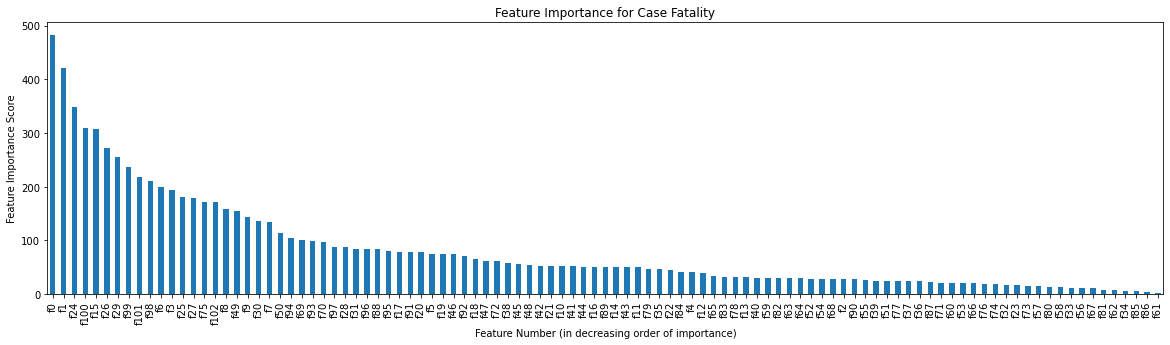

In [6]:
xgb1 = xgb.XGBClassifier(eta=0.1, max_depth=3, min_child_weight=2, n_estimators=200)
xgb1.fit(data, target1)                   

figure(figsize = (20,5))
feat_imp = pd.Series(xgb1.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importance for Case Fatality')
ylabel('Feature Importance Score')
xlabel('Feature Number (in decreasing order of importance)')
#savefig('1_FeatImp_case_fatality', dpi=200);

# Solution Visualization


Number of mislabeled points out of a total 1305 points : 541


C:\Users\William\anaconda3\envs\NDD\lib\site-packages\ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator


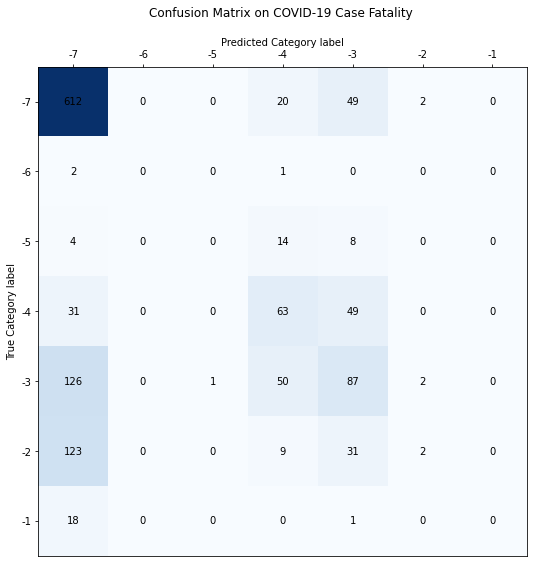

In [21]:
#Visualization with CV
from sklearn.metrics import confusion_matrix



#Data preparation
D = np.hstack((data, target1[:, newaxis]))
Dc = D.copy()

np.random.seed(seed=2019)
np.random.shuffle(Dc)

parti = 2
split = int(Dc[:,0].size/parti)
index = (parti-1) * split

X_train, C_train = Dc[:index, :103], Dc[:index, 103]
X_test, C_true = Dc[index:, :103], Dc[index:, 103]



#Target column selection
Target = 2 #incidence, mortality, case fatality

if Target == 0:
    clf = RandomForestClassifier(max_depth=7, random_state=seed)
    ticks = ['-','-10', '-9', '-8', '-7', '-6', '-5','-4','-3']
    label = [-10,-9,-8,-7,-6,-5,-4,-3]
    fileN = '2_CM_incidence'
    title = 'Incidence'
elif Target == 1:
    clf = xgb.XGBClassifier(eta=0.1, max_depth=1, min_child_weight=4, n_estimators=70)
    ticks = ['-','-14','-13','-12','-11','-10','-9','-8','-7']
    label = [-14,-13,-12,-11,-10,-9,-8,-7]
    fileN = '2_CM_mortality'
    title = 'Mortality'
elif Target == 2:
    clf = xgb.XGBClassifier(eta=0.1, max_depth=3, min_child_weight=7, n_estimators=50)
    ticks = ['-','-7','-6','-5','-4','-3','-2','-1']
    label = [-7,-6,-5,-4,-3,-2,-1]
    fileN = '2_CM_case_fatality'
    title = 'Case Fatality'
    
C_pred = clf.fit(X_train, C_train).predict(X_test)
print("Number of mislabeled points out of a total %3d points : %2d" % (X_test.shape[0],(C_true!=C_pred).sum()))

#Visualizing using a Color Map
CM = confusion_matrix(C_true, C_pred, labels=label); 

fig, ax = plt.subplots(figsize=(15, 9))
ax.matshow(CM, cmap=plt.cm.Blues)
ax.set(title='Confusion Matrix on COVID-19 ' + title + ' \n', ylabel='True Category label', xlabel='Predicted Category label');
ax.xaxis.set_ticklabels(ticks); ax.yaxis.set_ticklabels(ticks);
ax.xaxis.set_label_position('top'); ax.xaxis.tick_top();
for i in range(len(label)):
    for j in range(len(label)):
        c = CM[j,i]
        ax.text(i, j, str(c), va='center', ha='center')


savefig(fileN, dpi=200);

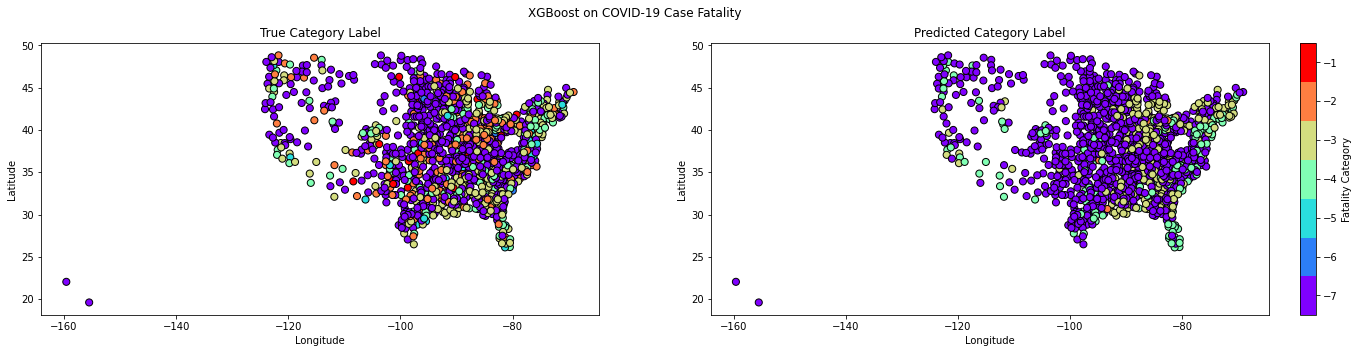

In [22]:
# Visualization using plot
i, j = 1, 0;
k, l = min(C_true), max(C_true);
fig = plt.figure(figsize=(22,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

fig.suptitle('XGBoost on COVID-19 Case Fatality')
p1 = ax1.scatter(X_test[:, i], X_test[:, j], c = C_true, cmap = cm.rainbow, s = 50, edgecolor = 'k');
ax1.set_title('True Category Label')
ax1.set_xlabel('Longitude');
ax1.set_ylabel('Latitude');
p2 = ax2.scatter(X_test[:, i], X_test[:, j], c = C_pred, cmap = cm.rainbow, s = 50, edgecolor = 'k', vmin=k, vmax=l);
ax2.set_title('Predicted Category Label');
ax2.set_xlabel('Longitude');
ax2.set_ylabel('Latitude');

bnd = unique(C_true) + 0.5
bnd = insert(bnd, 0, min(bnd)-1)
tik = unique(C_true)
cbar_ax = fig.add_axes([0.92,0.125,0.01,0.755]);
cbar = fig.colorbar(p1, cax=cbar_ax, boundaries=bnd, ticks=tik)
cbar.set_label('Fatality Category')


savefig('3_PLT_case_fatality', dpi=200);